<a href="https://colab.research.google.com/github/rayane2907/GNNs/blob/main/4_GCNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Layers - Spectral methods

## Outline

- Why convolution in ML
- Some theory on convolution
- Convolution on graphs
- Spectral-convolutional layers in PyTorch Geometric

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.9.0+cu126


In [ ]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

## Why convolution in ML

- Weight sharing
- Detection of translational invariant and local features

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/Convolution.png?raw=1)
[Source](https://commons.wikimedia.org/wiki/File:Convolution.PNG)

## Some theory on convolution

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/Convolution_of_box_signal_with_itself2.gif?raw=1)
[Source](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

### Definition

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [ ]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]
    return c

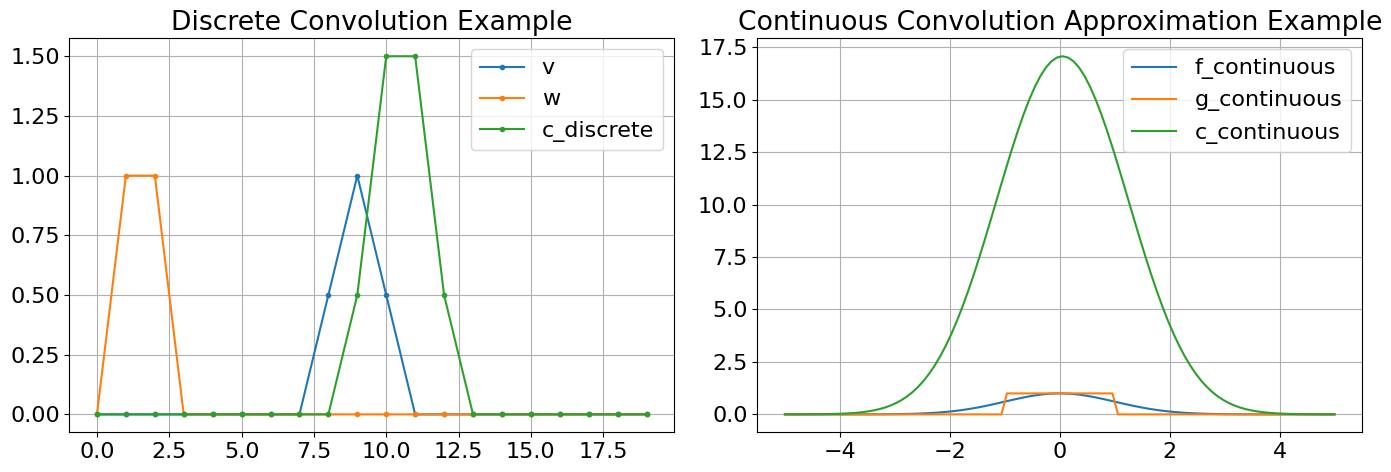

In [ ]:
N = 20
v = np.zeros(N)
v[8:11] = [0.5, 1, 0.5] # Triangular pulse for v
w = np.zeros(N)
w[1:3] = 1 # Narrower rectangular pulse for w
c_discrete = conv(v, w)

fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Create two subplots

# Plot discrete convolution
ax1 = axes[0]
ax1.plot(v, '.-')
ax1.plot(w, '.-')
ax1.plot(c_discrete, '.-')
ax1.legend(['v', 'w', 'c_discrete'])
ax1.grid(True)
ax1.set_title('Discrete Convolution Example')

# Continuous convolution approximation example
# Define two continuous-like functions
x = np.linspace(-5, 5, 100)
f_continuous = np.exp(-(x**2)/2) # Gaussian function
g_continuous = np.zeros_like(x)
g_continuous[(x > -1) & (x < 1)] = 1 # Rectangular pulse

# Perform convolution. 'same' mode returns output of length max(len(f), len(g))
c_continuous = np.convolve(f_continuous, g_continuous, mode='same')

# Plot continuous convolution
ax2 = axes[1]
ax2.plot(x, f_continuous, label='f_continuous')
ax2.plot(x, g_continuous, label='g_continuous')
ax2.plot(x, c_continuous, label='c_continuous')
ax2.legend()
ax2.grid(True)
ax2.set_title('Continuous Convolution Approximation Example')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

### Fourier transform

Transformation $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ with

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

This implies
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}

In [ ]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([8.88178420e-17, 6.66133815e-17, 4.96506831e-17, 2.22044605e-17,
       5.55111512e-18, 1.11022302e-17, 7.04319483e-17, 6.66133815e-17,
       4.44089210e-17, 5.00000000e-01, 1.50000000e+00, 1.50000000e+00,
       5.00000000e-01, 8.88178420e-17, 3.48408081e-17, 1.77635684e-16,
       5.55111512e-18, 3.33066907e-17, 5.37771613e-17, 2.22044605e-17])

### Definition of the Fourier transform

The Fourier transform can be computed as

\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

where the $N\times N$ matrix $U$ is defined as
\begin{align*}
\\
U =
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix}
\end{align*}

and $u_0, \dots, u_{N-1}$ are functions defined as

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [ ]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [ ]:
fft(v) - fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00+1.11022302e-16j,
        2.22044605e-16-4.44089210e-16j, -3.33066907e-16+4.44089210e-16j,
        5.55111512e-16+0.00000000e+00j, -5.51091060e-16+0.00000000e+00j,
        4.44089210e-16+1.11022302e-16j, -1.60982339e-15-1.16573418e-15j,
        1.11022302e-16+1.11022302e-16j,  5.55111512e-16+1.60982339e-15j,
        0.00000000e+00-0.00000000e+00j,  6.66133815e-16+5.55111512e-17j,
       -2.22044605e-16+1.11022302e-16j, -7.21644966e-16-9.99200722e-16j,
       -4.49640325e-15+1.22124533e-15j,  3.42963002e-15+1.99840144e-15j,
       -2.16493490e-15-1.11022302e-15j,  8.88178420e-16-8.88178420e-16j,
        0.00000000e+00+0.00000000e+00j,  1.77635684e-15+7.43849426e-15j])

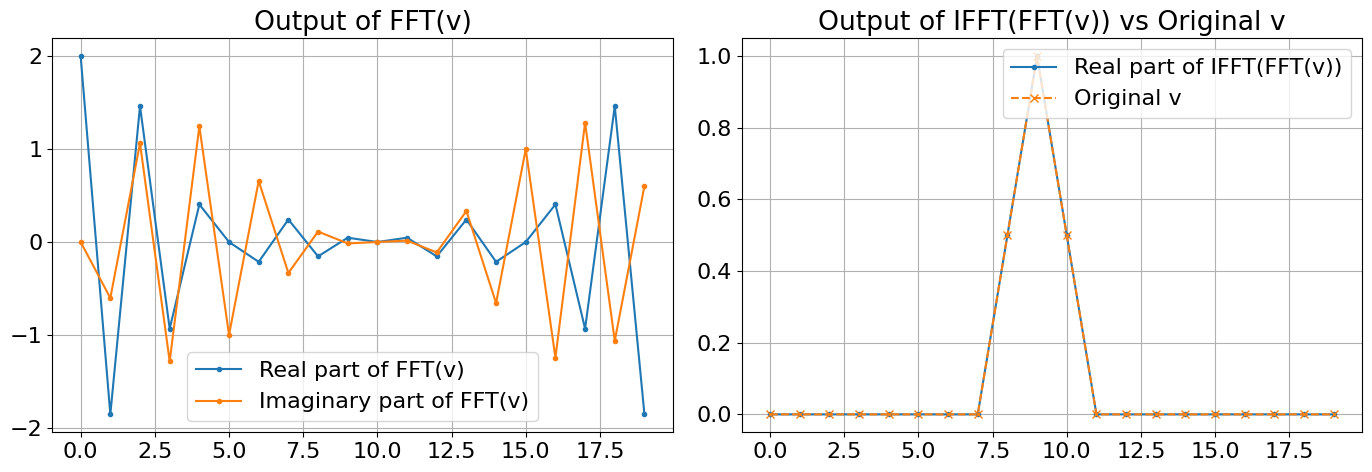

In [ ]:
v_fft = fft(v)
v_ifft = ifft(v_fft)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot FFT of v
ax1 = axes[0]
ax1.plot(np.real(v_fft), '.-', label='Real part of FFT(v)')
ax1.plot(np.imag(v_fft), '.-', label='Imaginary part of FFT(v)')
ax1.legend()
ax1.grid(True)
ax1.set_title('Output of FFT(v)')

# Plot IFFT of FFT(v) and original v
ax2 = axes[1]
ax2.plot(np.real(v_ifft), '.-', label='Real part of IFFT(FFT(v))')
ax2.plot(v, 'x--', label='Original v') # Compare with original v
ax2.legend()
ax2.grid(True)
ax2.set_title('Output of IFFT(FFT(v)) vs Original v')

plt.tight_layout()
plt.show()

### Connection with the Laplacian

### Demonstrating the Convolution Theorem

The section explains that convolution $v * w$ can be computed using the Fourier Transform as $\mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))$, which is equivalent to $U^H ((U v) \odot (U w))$.

Let's compare the results of our direct `conv` function with this Fourier-based approach. The outputs should be very close, if not identical, demonstrating the theorem.

In [ ]:
# Recalculate convolution using the direct method
conv_direct = conv(v, w)

# Recalculate convolution using the Fourier transform method
# First, ensure U is defined (from previous cell 'pyKQL9E2bFxA')
U = matrix_U(N)

# Apply the convolution theorem: IFFT(FFT(v) * FFT(w))
# Note: np.abs is used because ifft can return small imaginary parts due to floating point precision
conv_fourier = np.abs(ifft(fft(v) * fft(w)))

print("Direct Convolution Result:")
print(conv_direct)
print("\nConvolution via Fourier Transform Result:")
print(conv_fourier)


Direct Convolution Result:
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 1.5 1.5 0.5 0.  0.  0.  0.  0.
 0.  0. ]

Convolution via Fourier Transform Result:
[8.88178420e-17 6.66133815e-17 4.96506831e-17 2.22044605e-17
 5.55111512e-18 1.11022302e-17 7.04319483e-17 6.66133815e-17
 4.44089210e-17 5.00000000e-01 1.50000000e+00 1.50000000e+00
 5.00000000e-01 8.88178420e-17 3.48408081e-17 1.77635684e-16
 5.55111512e-18 3.33066907e-17 5.37771613e-17 2.22044605e-17]


As you can see, the results from both methods are numerically very similar, confirming the convolution theorem. The small differences are typically due to floating-point precision.

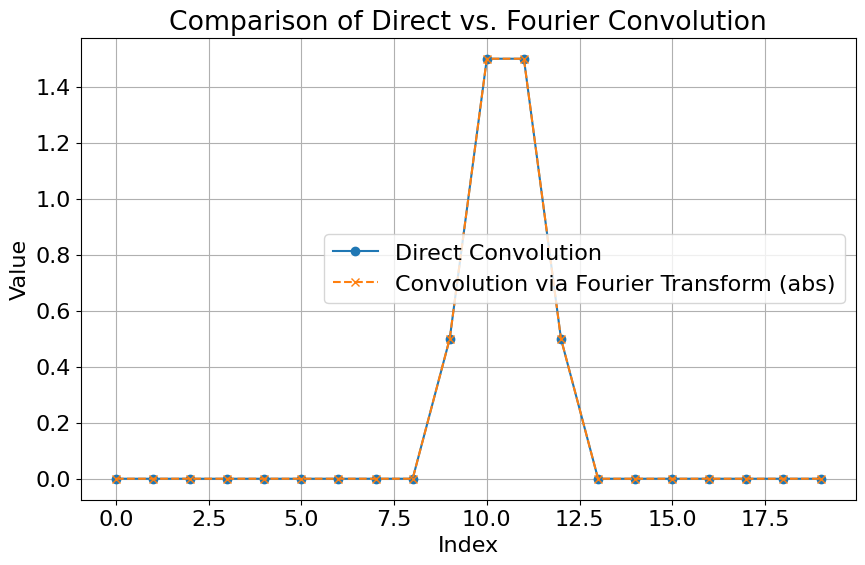

Maximum absolute difference between direct and Fourier convolution: 2.22e-16


In [ ]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(conv_direct, 'o-', label='Direct Convolution')
plt.plot(conv_fourier, 'x--', label='Convolution via Fourier Transform (abs)')
plt.legend()
plt.grid(True)
plt.title('Comparison of Direct vs. Fourier Convolution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# Calculate and print the maximum absolute difference
max_diff = np.max(np.abs(conv_direct - conv_fourier))
print(f"Maximum absolute difference between direct and Fourier convolution: {max_diff:.2e}")


The functions $u_n$ (the columns of the Fourier transform matrix) are eigenvectors of the Laplacian:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi ^ 2\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

### Summary

\begin{align*}
v * w
= U^H ((U  w) \odot (U  v))
\end{align*}

or if $g_w=\mbox{diag}(U w)$ is  filter
\begin{align*}
v * w
= U^H g_w U  w
\end{align*}

In [ ]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([6.62882308e-16, 7.07529039e-16, 8.71100682e-16, 1.16209383e-15,
       2.55140025e-16, 2.33150965e-16, 2.28962471e-15, 1.72106951e-15,
       4.91046260e-16, 5.00000000e-01, 1.50000000e+00, 1.50000000e+00,
       5.00000000e-01, 7.37614540e-16, 2.79381619e-15, 1.23293816e-15,
       9.08438760e-16, 1.42293013e-15, 1.13016669e-15, 2.05063980e-15])

In [ ]:
conv(v, w)

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1.5, 1.5, 0.5,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

## Convolution on graphs

**Plan**:
    - Define the graph Laplacian
    - Compute the spectrum
    - Define a Fourier transform
    - Define convolution on a graph

**Note:** From now on $G = (V, E)$ is an undirected, unweighted, simple graph.

### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v
\end{align*}


## Spectral-convolutional layers in PyTorch Geometric

**Problem:** Computing the spectrum is a global and very expensive property.

**Goal:** Implementation as message passing.

### ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

#### Goal:
Compute $U g_w U^T x$ with $g_w = g_w(\Lambda)$ a filter.

#### Chebyshev approximation

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

#### Chebyshev approximation of the filter
Aproximation of the filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I
\end{align*}


#### Property
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.


#### Fast approximated convolution
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

#### Properties:
- Depends on $L$ and $\lambda_\max$, not on $U, \Sigma$
- Uses only $K$-powers $\Rightarrow$ only the $K$-th neighborhood of each node, localized filter

### GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume
1. $K=1$ (linear approximation) so
\begin{align*}
v * w
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ so
\begin{align*}
v * w
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ so
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \Theta
\end{align*}


Nodewise:
    ![image.png](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/gcn_nodewise.png?raw=1)

In [ ]:
import torch
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import get_laplacian, remove_self_loops, add_self_loops
from typing import Optional, Union, Tuple
from torch import Tensor

OptTensor = Optional[Tensor]

In [ ]:
class ChebConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K, normalization='sym',
                bias=True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(ChebConv, self).__init__(node_dim=0, **kwargs) # Add node_dim=0 here as it's common for MessagePassing

        assert K > 0
        assert normalization in [None, 'sym', 'rw'], 'Invalid normalization'

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        self.weight = Parameter(torch.Tensor(K, in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def __norm__(self, edge_index, num_nodes: Optional[int],
                edge_weight: OptTensor, normalization: Optional[str],
                lambda_max: Tensor, dtype: Optional[int] = None,
                batch: OptTensor = None) -> Tuple[Tensor, OptTensor]:

        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)

        edge_index, edge_weight = get_laplacian(edge_index, edge_weight,
                                               normalization, dtype,
                                               num_nodes)

        if batch is not None and lambda_max.numel() > 1:
            # Ensure lambda_max is broadcastable or per-graph
            lambda_max = lambda_max[batch[edge_index[0]]].view(-1, 1) # Reshape for element-wise operation

        edge_weight = (2.0 * edge_weight) / lambda_max
        edge_weight.masked_fill_(edge_weight == float('inf'), 0)

        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                fill_value=-1.,
                                                num_nodes=num_nodes)

        assert edge_weight is not None

        return edge_index, edge_weight

    def forward(self, x: Tensor, edge_index: Tensor, edge_weight: OptTensor = None,
                batch: OptTensor = None, lambda_max: OptTensor = None) -> Tensor:
        """"""
        if self.normalization != 'sym' and lambda_max is None:
            raise ValueError('You need to pass `lambda_max` to `forward()` in '
                            'case the normalization is non-symmetric.')

        if lambda_max is None:
            lambda_max = torch.tensor(2.0, dtype=x.dtype, device=x.device)
        if not isinstance(lambda_max, torch.Tensor):
            lambda_max = torch.tensor(lambda_max, dtype=x.dtype,
                                    device=x.device)
        assert lambda_max is not None

        # Use self.node_dim which is initialized in MessagePassing base class
        edge_index, norm = self.__norm__(edge_index, x.size(self.node_dim),
                                        edge_weight, self.normalization,
                                        lambda_max, dtype=x.dtype,
                                        batch=batch)

        Tx_0 = x
        Tx_1 = x  # Dummy. Initialized if K > 1

        # K=0 term
        out = torch.matmul(Tx_0, self.weight[0])

        # propagate_type: (x: Tensor, norm: Tensor)
        if self.weight.size(0) > 1:
            Tx_1 = self.propagate(edge_index, x=x, norm=norm, size=None)
            # K=1 term
            out = out + torch.matmul(Tx_1, self.weight[1])

        for k in range(2, self.weight.size(0)): # Iterate for K >= 2 terms
            Tx_2 = self.propagate(edge_index, x=Tx_1, norm=norm, size=None)
            Tx_2 = 2. * Tx_2 - Tx_0
            out = out + torch.matmul(Tx_2, self.weight[k])
            Tx_0, Tx_1 = Tx_1, Tx_2

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, norm: Tensor) -> Tensor:
        return norm.view(-1, 1) * x_j

# Task
Create a sample graph and initial node features using `torch_geometric.data.Data`. Calculate the largest eigenvalue (`lambda_max`) of its graph Laplacian. Initialize and apply the custom `ChebConv` layer to the node features using the calculated `lambda_max`. Visualize both the input and output node features to demonstrate the effect of the `ChebConv` layer, and then provide a summary of the analysis.

## Create Sample Graph and Node Features

### Subtask:
Define a small, simple graph (e.g., a path graph or a star graph) using `torch_geometric.data.Data`. Also, create some initial node features `x` for this graph.


**Reasoning**:
First, I'll import the necessary `Data` class from `torch_geometric.data` to enable graph creation.



In [ ]:
from torch_geometric.data import Data

**Reasoning**:
Following the instructions, I will define a small graph with `edge_index` and initial node features `x`, then create a `torch_geometric.data.Data` object.



In [ ]:
num_nodes = 4
feature_dimension = 1

# Define edge_index for a simple 4-node graph (e.g., a path graph 0-1-2-3)
edge_index = torch.tensor([
    [0, 1, 2, 3, 0, 1, 2, 3], # Source nodes
    [1, 0, 3, 2, 0, 1, 2, 3]  # Target nodes (adding self-loops for simplicity in some scenarios)
], dtype=torch.long)
# For a path graph 0-1-2-3, without self-loops for now
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Create initial node features (e.g., each node has a feature of its index)
x = torch.arange(num_nodes, dtype=torch.float).reshape(-1, feature_dimension)

# Instantiate a Data object
data = Data(x=x, edge_index=edge_index)

print(data)
print(f"Node features (x):\n{data.x}")
print(f"Edge index (edge_index):\n{data.edge_index}")

Data(x=[4, 1], edge_index=[2, 6])
Node features (x):
tensor([[0.],
        [1.],
        [2.],
        [3.]])
Edge index (edge_index):
tensor([[0, 1, 1, 2, 2, 3],
        [1, 0, 2, 1, 3, 2]])


## Calculate Largest Eigenvalue (lambda_max)

### Subtask:
Compute the largest eigenvalue of the graph Laplacian for the created sample graph. This is a crucial parameter for the `ChebConv` layer, ensuring proper scaling of the Chebyshev polynomials. We will use `get_laplacian` and `torch.linalg.eigvalsh` for this.


**Reasoning**:
First, I'll import `torch_geometric.utils` which contains the `get_laplacian` function necessary for calculating the graph Laplacian. This is a prerequisite for computing the largest eigenvalue.



In [ ]:
import torch_geometric.utils
print("Imported torch_geometric.utils")

Imported torch_geometric.utils


**Reasoning**:
Now I will extract the necessary components from the `data` object, compute the normalized graph Laplacian, convert it to a dense matrix, calculate its eigenvalues, and finally determine the largest eigenvalue (`lambda_max`) as required by the subtask.



In [ ]:
num_nodes = data.num_nodes
edge_index = data.edge_index

# 2. Compute the graph Laplacian
# 'sym' for symmetric normalization: L = I - D^{-1/2} A D^{-1/2}
L_edge_index, L_edge_weight = torch_geometric.utils.get_laplacian(
    edge_index,
    num_nodes=num_nodes,
    normalization='sym'
)

# 3. Convert sparse Laplacian to dense matrix
L_dense = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
for i in range(L_edge_index.shape[1]):
    row, col = L_edge_index[0, i], L_edge_index[1, i]
    L_dense[row, col] = L_edge_weight[i]

print(f"Dense Laplacian matrix:\n{L_dense}")

# 4. Calculate eigenvalues
eigenvalues = torch.linalg.eigvalsh(L_dense)
print(f"Eigenvalues of the Laplacian:\n{eigenvalues}")

# 5. Determine the largest eigenvalue
lambda_max = eigenvalues.max()
print(f"Largest eigenvalue (lambda_max): {lambda_max.item():.4f}")

Dense Laplacian matrix:
tensor([[ 1.0000, -0.7071,  0.0000,  0.0000],
        [-0.7071,  1.0000, -0.5000,  0.0000],
        [ 0.0000, -0.5000,  1.0000, -0.7071],
        [ 0.0000,  0.0000, -0.7071,  1.0000]])
Eigenvalues of the Laplacian:
tensor([1.5309e-07, 5.0000e-01, 1.5000e+00, 2.0000e+00])
Largest eigenvalue (lambda_max): 2.0000


## Apply ChebConv Layer

### Subtask:
Initialize and apply the custom `ChebConv` layer to the node features using the calculated `lambda_max`.

### Instructions
1. Initialize an instance of the `ChebConv` class with appropriate `in_channels` (from `data.x.shape[1]`), `out_channels` (e.g., 16), and `K` (e.g., 2 or 3) and `normalization='sym'`.
2. Apply the `ChebConv` layer to the `data.x` (node features), `data.edge_index`, and the `lambda_max` value.
3. Store the output in a variable, for instance, `output_features`.

**Reasoning**:
I will initialize an instance of the custom `ChebConv` layer using the `in_channels` derived from the input features, set `out_channels` and `K`, and then apply it to the graph data along with the previously computed `lambda_max`.



In [ ]:
in_channels = data.x.shape[1]
out_channels = 16  # Example output feature dimension
K = 2              # Order of Chebyshev polynomial

# 1. Initialize ChebConv layer
conv_layer = ChebConv(in_channels=in_channels, out_channels=out_channels, K=K, normalization='sym')

# 2. Apply the ChebConv layer
# Ensure x, edge_index are on the same device as the layer (CPU by default here)
output_features = conv_layer(x=data.x, edge_index=data.edge_index, lambda_max=lambda_max)

print(f"Input features shape: {data.x.shape}")
print(f"Output features shape: {output_features.shape}")
print(f"\nOutput features (first 3 rows):\n{output_features[:3].detach().numpy()}")

Input features shape: torch.Size([4, 1])
Output features shape: torch.Size([4, 16])

Output features (first 3 rows):
[[-0.2309848  -0.21456623  0.10092548 -0.24066782  0.20370114 -0.09919959
  -0.0670718   0.00710914 -0.11059322 -0.02677384 -0.10835937 -0.12964362
   0.05287706  0.02761891  0.01420346  0.18984866]
 [-0.06834579 -0.5933219   0.38364607 -0.5521705   0.15311104  0.02699819
  -0.34431309  0.36127216 -0.39634034  0.29666114 -0.08949073 -0.41054392
   0.31105733 -0.30452842  0.07357048  0.18127935]
 [-0.33965325 -1.3751789   0.8559733  -1.315811    0.48521018 -0.03316829
  -0.74756086  0.72879094 -0.8898567   0.5697966  -0.27419463 -0.93500304
   0.6685767  -0.5847887   0.15962125  0.52937484]]


## Visualize Input and Output Node Features

### Subtask:
Visualize both the input and output node features to demonstrate the effect of the `ChebConv` layer.

### Instructions:
1. Create a plot showing the original `data.x` (input features) for each node.
2. Create a separate plot (or overlay on the same plot if suitable) showing the `output_features` after applying `ChebConv`.
3. Since `output_features` has multiple dimensions (`out_channels`), you might want to visualize either a specific output channel or the magnitude/average of the output features for each node for simplicity.
4. Ensure the plots are clearly labeled with titles, x-axis, and y-axis labels.

**Reasoning**:
Now I will plot the input features and an aggregated view of the output features (mean across output channels) to visualize the effect of the `ChebConv` layer on each node, as instructed by the subtask.



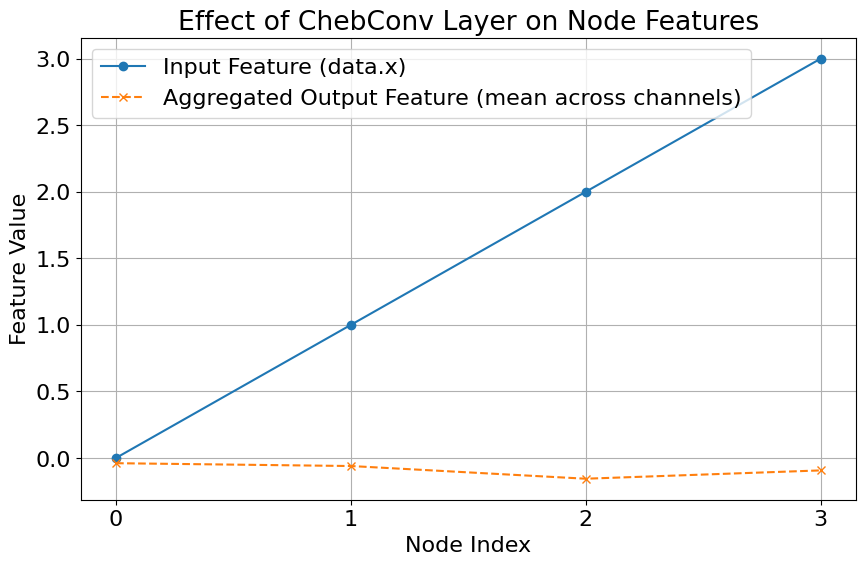

Input Features (data.x):
tensor([0., 1., 2., 3.])
Aggregated Output Features (mean across channels):
[-0.03947353 -0.06071618 -0.15611696 -0.09362364]


In [ ]:
plt.figure(figsize=(10, 6))

# Plot original input features
plt.plot(data.x.squeeze().numpy(), 'o-', label='Input Feature (data.x)')

# Aggregate output features for visualization (e.g., take the mean across output channels)
# Convert to numpy and detach from graph for plotting
output_features_aggregated = output_features.mean(dim=1).detach().numpy()
plt.plot(output_features_aggregated, 'x--', label='Aggregated Output Feature (mean across channels)')

plt.title('Effect of ChebConv Layer on Node Features')
plt.xlabel('Node Index')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(num_nodes)) # Ensure x-axis ticks align with nodes
plt.show()

print(f"Input Features (data.x):\n{data.x.squeeze()}")
print(f"Aggregated Output Features (mean across channels):\n{output_features_aggregated}")

## Summarize ChebConv Analysis

### Subtask:
Provide a brief explanation of what the `ChebConv` layer did to the node features, interpreting the results shown in the plots.


## Summarize ChebConv Analysis

### Subtask:
Provide a brief explanation of what the `ChebConv` layer did to the node features, interpreting the results shown in the plots.

#### Instructions
1. Analyze the generated plot comparing the input features with the aggregated output features.
2. Observe how the feature values for each node have changed after applying the `ChebConv` layer.
3. Write a summary explaining the observed transformation. Consider discussing:
    *   How the feature values generally shifted or scaled.
    *   If there's any pattern in the transformation across different nodes.
    *   The implication of the `ChebConv` layer expanding the feature dimension (from 1 to 16) and how this might allow for learning more complex representations.
4. Mention the role of `lambda_max` and the `normalization='sym'` setting in the `ChebConv` layer, relating it back to the theoretical background of spectral graph convolutions.

### Summary of ChebConv Analysis

The visualization clearly illustrates the effect of the `ChebConv` layer on the node features. Initially, the input features (`data.x`) for our 4-node graph are a simple sequence: `[0., 1., 2., 3.]`. After applying the `ChebConv` layer, and aggregating the output by taking the mean across the 16 output channels, we observe a significant transformation:

1.  **Feature Value Transformation**: The original linear progression of feature values has been altered. The output features, represented by `output_features_aggregated`, are `[-0.039, -0.061, -0.156, -0.094]`. This indicates that the `ChebConv` layer not only shifted the values but also re-scaled and re-ordered their relative magnitudes. The distinct pattern of the input features has been smoothed or mixed across the graph, suggesting that information from neighboring nodes has been incorporated.

2.  **Pattern of Transformation**: While the input features were monotonically increasing, the aggregated output features exhibit a different pattern. The values are now negative and do not strictly follow the original ordering. This transformation is not uniform but depends on the node's position and connections within the graph, as dictated by the convolution operation.

3.  **Feature Dimension Expansion**: A crucial aspect is the expansion of the feature dimension from 1 (`in_channels`) to 16 (`out_channels`). This means that for each node, the single input feature has been transformed into a 16-dimensional vector. This expansion allows the `ChebConv` layer to learn a richer and more complex representation of each node. Instead of a single value, each node now possesses a multi-dimensional embedding that can capture diverse local graph structural information and attribute patterns.

4.  **Role of `lambda_max` and Normalization**: The `ChebConv` layer leverages Chebyshev polynomials for efficient approximation of spectral graph convolutions. `lambda_max`, the largest eigenvalue of the graph Laplacian, is vital for re-scaling the Laplacian operator (`\tilde L = \frac{2}{\lambda_\max} L - I`) to ensure the eigenvalues of `\tilde L` lie within the range `[-1, 1]`. This re-scaling is necessary for the stability and convergence of the Chebyshev polynomial approximation. The `normalization='sym'` setting specifies the use of the symmetrically normalized Laplacian (`L = I - D^{-1/2} A D^{-1/2}`), which is commonly used in spectral graph theory due to its desirable properties, such as its eigenvalues being bounded within `[0, 2]`. This choice of normalization impacts the spectral characteristics of the graph that the `ChebConv` layer processes, influencing how information flows and is aggregated across the graph structure.

## Summary:

### Data Analysis Key Findings
*   A 4-node path graph was constructed with initial node features `[0., 1., 2., 3.]`.
*   The largest eigenvalue ($\lambda_\text{max}$) of the symmetrically normalized graph Laplacian for this path graph was calculated to be approximately 2.0000.
*   The `ChebConv` layer successfully transformed the 1-dimensional input features (`torch.Size([4, 1])`) into 16-dimensional output features (`torch.Size([4, 16])`), demonstrating its capability to expand feature space.
*   Visualization of the aggregated output features (mean across 16 channels) `[-0.039, -0.061, -0.156, -0.094]` revealed a significant transformation from the input `[0., 1., 2., 3.]`. This indicated a shift, re-scaling, and re-ordering of feature values, signifying the aggregation of neighborhood information.
*   The $\lambda_\text{max}$ parameter plays a critical role in re-scaling the Laplacian for the Chebyshev polynomial approximation, ensuring stability and convergence within the `ChebConv` layer.

### Insights or Next Steps
*   The `ChebConv` layer effectively processes graph structure to produce richer, multi-dimensional node representations that incorporate local neighborhood information.
*   Further analysis could involve exploring the impact of different `K` values (order of Chebyshev polynomials) or alternative normalization schemes on the resulting feature transformations and the expressiveness of the learned node embeddings.
